# Main notebook to process indexed datasets into summaries.

## Generate sentence pairs

In [187]:
import itertools
import json
import nltk
import pandas as pd

In [22]:
save_dir = input("enter path to base directory to save outputs to:\n")

enter path to base directory to save outputs to:
 ../data/test6.2


In [381]:
input_path = input("enter path to indexed dataset:\n")  # default encoding is utf-8
with open(input_path) as f:
    sents_df = pd.read_csv(f, delimiter=',')
sents_df.head()

enter path to indexed dataset:
 ../data/tmp/TrumpBiden2.csv


,index,sentence
0,0,Trump is going to make America great again.
1,1,Trump is ruining America.
2,2,President Donald Trump is the greatest president.
3,3,Experts have condemned Trump for irresponsible...
4,4,Joe Biden is leading in the preliminary polls.


In [382]:
indices = list(sents_df.index)

# generate all pairs in the set of sentences.
indices_list = list(itertools.combinations(indices, 2))
print('no. of sentences: ', len(indices))
print('no. of sentence pairs: ', len(indices_list), '\n')

no. of sentences:  35
no. of sentence pairs:  595 



In [383]:
# generate all sentence pairs and save into a csv for manual labelling.
data = []
for pair in indices_list:
    data.append([pair[0], pair[1], sents_df.iloc[pair[0]]['sentence'], sents_df.iloc[pair[1]]['sentence']])

df = pd.DataFrame(data=data, columns=['first_index', 'second_index', 'first', 'second'])
display(df)

,first_index,second_index,first,second
0,0,1,Trump is going to make America great again.,Trump is ruining America.
1,0,2,Trump is going to make America great again.,President Donald Trump is the greatest president.
2,0,3,Trump is going to make America great again.,Experts have condemned Trump for irresponsible...
3,0,4,Trump is going to make America great again.,Joe Biden is leading in the preliminary polls.
4,0,5,Trump is going to make America great again.,Trump's erratic behaviour ignores worsening pa...
...,...,...,...,...
590,31,33,Biden was so easy-going and relaxed.,Joe Biden's remarks were racist and dehumanizing.
591,31,34,Biden was so easy-going and relaxed.,"In most ways, Biden is the worst candidate for..."
592,32,33,Biden's remarks were clumsy and off-putting bu...,Joe Biden's remarks were racist and dehumanizing.
593,32,34,Biden's remarks were clumsy and off-putting bu...,"In most ways, Biden is the worst candidate for..."


In [384]:
is_save = input('save indexed paired dataset? (y/n):\n')
if is_save.lower() == 'y':
    df.to_csv(save_dir + '/' + 'paired_sentences.csv')
else:
    print('not saving indexed paired dataset.')

save indexed paired dataset? (y/n):
 y


## Perform inferences of distances between sentences in a sentence pair

In [367]:
import torch
from fairseq.data.data_utils import collate_tokens
from math import exp
import numpy as np

class RobertaMNLI:
    # todo: create similar wrapper classes for other NLI engines.
    # todo: create a wrapper superclass and subclass from there.
    
    def __init__(self, rel_path):
        """
        :param rel_path: relative path to pytorch hub directory.
        """
        self.output_map = {
            0: 'contradiction',
            1: 'neutral',
            2: 'entailment'
        }
        
        torch.hub.set_dir(rel_path)
        self.roberta = torch.hub.load('pytorch/fairseq', 'roberta.large.mnli')  # works
        self.roberta.cuda()
        self.roberta.eval()
        
    def predict_one(self, S1, S2, return_probs=False):
        batch = collate_tokens(
            [self.roberta.encode(S1, S2)], pad_idx=1
        )
        logprobs = self.roberta.predict('mnli', batch)
        classes_tsr = logprobs.argmax(dim=1)
        classes = classes_tsr.tolist()  
        
        if return_probs == True:
            logprobs_list=[logprob.item() for logprob in logprobs[0]]
            prob_list =  [pow(exp(1), logprob) for logprob in logprobs_list]
            return prob_list
        else:
            return classes[0]  # 0 is contradiction, 1 is neutral, 2 is entailment.

In [11]:
predictor = RobertaMNLI(rel_path="../../roberta/hub")

Using cache found in ../../roberta/hub\pytorch_fairseq_master


In [385]:
results = list()
for i in range(len(df)):
    s1 = df.iloc[i]['first']
    s2 = df.iloc[i]['second']
    CNE1 = predictor.predict_one(s1, s2, return_probs=True)
    CNE2 = predictor.predict_one(s2, s1, return_probs=True)
    row = CNE1+ CNE2
    results.append(row)

scores_df = pd.DataFrame(data=results, columns=['C1', 'N1', 'E1', 'C2', 'N2', 'E2'])

In [386]:
def gen_dist2(row):
    '''
    Generate distance score based on Contradiction, Entailment and Neutrality probabilities for both directions.
    Assumes that C+E+N=1.
    '''    
    max1 = max([row['C1'], row['E1'], row['N1']])
    max2 = max([row['C2'], row['E2'], row['N2']])
    if max1 > max2:
        C, E, N = row['C1'], row['E1'], row['N1']
    else:
        C, E, N = row['C2'], row['E2'], row['N2']
    
    if C > 0.5:
        return C
    elif C == E:
        return 0.5
    else:
        return N/(N+E)*0.5

In [387]:
dist_ser = scores_df.apply(lambda row: gen_dist2(row), axis=1)
dist_ser.name = 'dist'
scores_df = scores_df.join(dist_ser)
scores_df = df.join(scores_df)
scores_df.to_csv(save_dir + '/' + 'nliScores.csv')

In [388]:
scores_df.head()

,first_index,second_index,first,second,C1,N1,E1,C2,N2,E2,dist
0,0,1,Trump is going to make America great again.,Trump is ruining America.,0.999377,0.000455,0.000167,0.999248,0.000537,0.000214,0.999377
1,0,2,Trump is going to make America great again.,President Donald Trump is the greatest president.,0.006336,0.925913,0.067751,0.000545,0.993994,0.005462,0.497268
2,0,3,Trump is going to make America great again.,Experts have condemned Trump for irresponsible...,0.795445,0.202652,0.001902,0.674856,0.323058,0.002086,0.795445
3,0,4,Trump is going to make America great again.,Joe Biden is leading in the preliminary polls.,0.959141,0.037226,0.003633,0.765069,0.225210,0.009721,0.959141
4,0,5,Trump is going to make America great again.,Trump's erratic behaviour ignores worsening pa...,0.364072,0.631232,0.004696,0.489559,0.507374,0.003067,0.496308


## Clustering based on precomputed pairwise distances.

In [19]:
import numpy as np
import pandas as pd

# import scipy
# from scipy.cluster.hierarchy import dendrogram,linkage
# from scipy.cluster.hierarchy import fcluster
# from scipy.cluster.hierarchy import cophenet
# from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

In [23]:
sents_df = pd.read_csv("../data/test6/TrumpBiden2.csv", delimiter=',')
scores_df = pd.read_csv("../data/test6/nliScores.csv", delimiter=',')

In [24]:
# convert pairwise distances to a distance matrix.
# we utilise a pivot table to do this

# first, redundant pairs, e.g. (sentence_1,sentence_1) are missing.
# add the redundant pairs to the df.
# we need this for the pivot function to generate the correct indices and columns.
first = np.unique(scores_df['first_index'].values)
second = np.unique(scores_df['second_index'].values)
combined_arr = np.concatenate((first, second))
sentences = np.unique(combined_arr)
add_data = np.column_stack([sentences, sentences, np.zeros(len(sentences))])
add_data = add_data.astype(np.int)

add_df = pd.DataFrame(data=add_data, columns=['first_index','second_index','dist'])
scores_df = scores_df.append(add_df, ignore_index=True)
df_piv = scores_df.pivot("first_index", "second_index", "dist").fillna(0)
piv_arr = df_piv.values
dist_mat = piv_arr + np.transpose(piv_arr)

In [ ]:
# generate pairwise matrix for saving.
intersentence = pd.DataFrame(data=dist_mat, index=df_piv.index, columns=df_piv.columns)
path = save_dir + '/' + 'pairwiseMatrix.csv'
intersentence.to_csv(path)

In [15]:
# LOAD pairwise matrix

# load intersentence pairwise distance matrix.
df_piv = pd.read_csv("../data/test6/pairwiseMatrix.csv")
print("loaded data from disk.")
display(df_piv.head())
df_piv = df_piv.drop(columns=['first_index'])
display(df_piv.head())
dist_mat = df_piv.values

loaded data from disk.


,first_index,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
0,0,0.000000,0.999377,0.497268,0.795445,0.959141,0.496308,0.499601,0.498059,0.499343,...,0.499489,0.498204,0.938643,0.800224,0.922200,0.916952,0.906209,0.499308,0.487592,0.498258
1,1,0.999377,0.000000,0.998932,0.498630,0.859179,0.491194,0.498060,0.913350,0.499525,...,0.499424,0.499098,0.492822,0.489934,0.930882,0.497926,0.936455,0.499304,0.492334,0.498649
2,2,0.497268,0.998932,0.000000,0.976655,0.950723,0.874225,0.497950,0.495002,0.490712,...,0.499028,0.496897,0.940679,0.906693,0.884726,0.989999,0.958454,0.498451,0.466004,0.497700
3,3,0.795445,0.498630,0.976655,0.000000,0.747706,0.499519,0.499331,0.498622,0.499234,...,0.499114,0.499296,0.499027,0.442380,0.484455,0.496694,0.752401,0.498135,0.443967,0.499289
4,4,0.959141,0.859179,0.950723,0.747706,0.000000,0.788093,0.897286,0.889479,0.895928,...,0.490936,0.434722,0.470062,0.499207,0.498854,0.499184,0.499434,0.499532,0.498011,0.844230


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.000000,0.999377,0.497268,0.795445,0.959141,0.496308,0.499601,0.498059,0.499343,0.499283,...,0.499489,0.498204,0.938643,0.800224,0.922200,0.916952,0.906209,0.499308,0.487592,0.498258
1,0.999377,0.000000,0.998932,0.498630,0.859179,0.491194,0.498060,0.913350,0.499525,0.916501,...,0.499424,0.499098,0.492822,0.489934,0.930882,0.497926,0.936455,0.499304,0.492334,0.498649
2,0.497268,0.998932,0.000000,0.976655,0.950723,0.874225,0.497950,0.495002,0.490712,0.492632,...,0.499028,0.496897,0.940679,0.906693,0.884726,0.989999,0.958454,0.498451,0.466004,0.497700
3,0.795445,0.498630,0.976655,0.000000,0.747706,0.499519,0.499331,0.498622,0.499234,0.886658,...,0.499114,0.499296,0.499027,0.442380,0.484455,0.496694,0.752401,0.498135,0.443967,0.499289
4,0.959141,0.859179,0.950723,0.747706,0.000000,0.788093,0.897286,0.889479,0.895928,0.943178,...,0.490936,0.434722,0.470062,0.499207,0.498854,0.499184,0.499434,0.499532,0.498011,0.844230


2 :  0.12335634128971232
3 :  0.22333303425123602
4 :  0.1617616346913586
5 :  0.14869726814616277
6 :  0.10310147625104718
7 :  0.09741430604736769
8 :  0.1121216792666212
9 :  0.09739136223940628
10 :  0.11086995082261247
11 :  0.1358805446669116
12 :  0.13379374957881937
13 :  0.1363979911958426
14 :  0.13858782818882845
15 :  0.1412729241986722
16 :  0.17552119950411715
17 :  0.1749182744277438
18 :  0.172759653108656
19 :  0.1846545768746672
20 :  0.20450426348972875
21 :  0.23522376684019422
22 :  0.23503782866999784
23 :  0.23589422224700815
24 :  0.23671171799422172
25 :  0.23755060030764252
26 :  0.23359194041180176
27 :  0.22902180621623047
28 :  0.22389711382723868
29 :  0.2174783822800523
30 :  0.20610294235089235
31 :  0.18447319504779283
32 :  0.14647127534573642
33 :  0.10561015734927548
34 :  0.05680982847820194


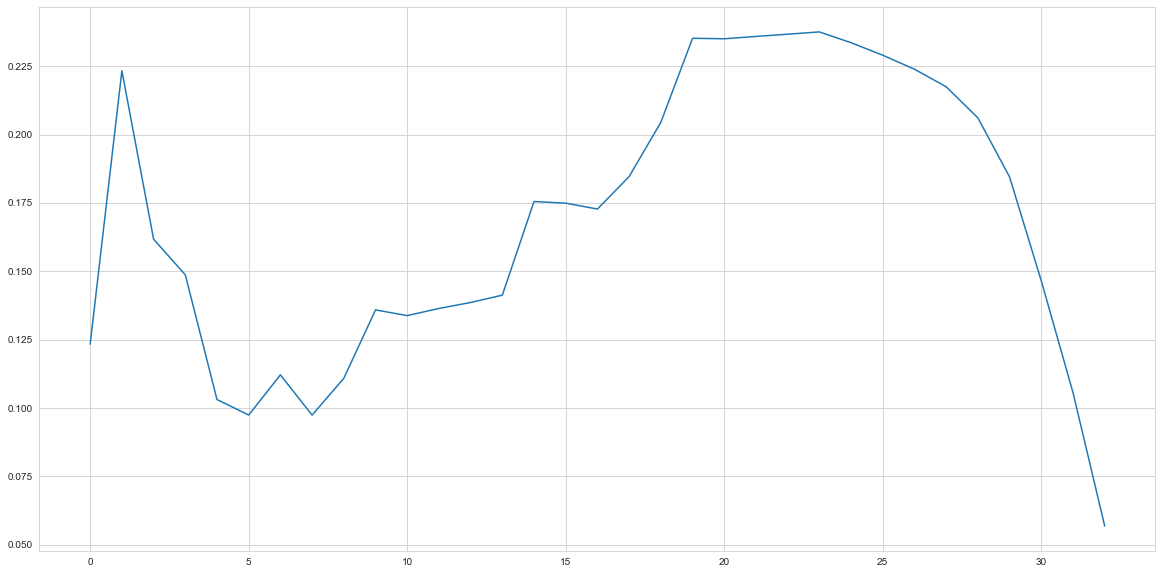

In [26]:
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
condensed_mat = squareform(dist_mat)
linkage = 'complete'

sil_scores = []  # silhouette scores
for i in range(2, len(dist_mat)):
    clusters = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage=linkage)
    clusters.fit_predict(dist_mat)

    # use metric to measure/compare goodness of clusters based on internal coherence and 
    # external coupling. we can consider maximising the Dunn index.
    # or consider average sillhouette width (maximise), which is available in sklearn.
    silhouette_avg = silhouette_score(dist_mat, clusters.labels_, metric='precomputed')
    sil_scores.append(silhouette_avg)
    print(i, ": ", silhouette_avg)
plt.plot(sil_scores)

In [17]:
sil_scores_arr = np.asarray(sil_scores)
print('max avg silhouette score: ', sil_scores_arr.max())
OPTIMAL_K = np.where(sil_scores_arr == sil_scores_arr.max())[0][0] + 2
print('nclusters w max avg silhouette score: ', OPTIMAL_K)

max avg silhouette score:  0.23755060030764252
nclusters w max avg silhouette score:  25


In [18]:
selected_k = 6
clusters = AgglomerativeClustering(n_clusters=selected_k, affinity='precomputed', linkage=linkage)
clusters.fit_predict(dist_mat)
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    
    print(f'cluster {i} (size {len(indices)}):')
    print(indices)
    for idx in indices:
        display(sents_df.iloc[idx]['sentence'])
    print('\n')

cluster 0 (size 4):
[ 4 26 30 31]


'Joe Biden is leading in the preliminary polls.'

'President Trump has repeatedly lied about the coronavirus.'

'Biden has a presidential aura.'

'Biden was so easy-going and relaxed.'



cluster 1 (size 7):
[ 0  2  7 10 18 19 34]


'Trump is going to make America great again.'

'President Donald Trump is the greatest president.'

'Trump says virus situation is under control.'

'Donald Trump is intelligent.'

'Trump is generous.'

'Donald Trump is smart.'

'In most ways, Biden is the worst candidate for the Democrats and the best opponent for Trump.'



cluster 2 (size 7):
[ 8 15 20 21 22 23 24]


'Donald Trump is controversial.'

'We cannot ignore the hate that Mr. Trump both encourages and allows to flourish. '

'Trump is a crackhead.'

'Trump is unhinged.'

'Trump sounded arrogant.'

"Trump's comments were puzzling."

"Trump's behaviour was chaotic and disruptive."



cluster 3 (size 5):
[12 13 25 28 29]


'Joe Biden is likable.'

'Joe Biden is genuine.'

'Trump was lying throughout much of the debate.'

'Biden seemed professional.'

'Biden showed restraint and compassion.'



cluster 4 (size 9):
[ 1  3  5  6 14 16 27 32 33]


'Trump is ruining America.'

'Experts have condemned Trump for irresponsible behaviour.'

"Trump's erratic behaviour ignores worsening pandemic."

"Trump's focus remains on himself even as virus rages."

'Joe Biden is intelligent.'

'Some see a Trump presidency as an existential threat to liberty and justice in the best sense of the American promise.'

'Trump has been consistently unreliable across the eight-month arc of our national crisis.'

"Biden's remarks were clumsy and off-putting but he had the right to ask that question."

"Joe Biden's remarks were racist and dehumanizing."



cluster 5 (size 3):
[ 9 11 17]


'Donald Trump is patriotic.'

'Donald Trump is passionate.'

"Trump's always been generous with his money to good causes and for no political reason what so ever."

In [395]:
# save clusters into JSON dict
clusters_dict = dict()
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    sents = list()
    for idx in indices:
        sents.append(int(df_piv.index[idx]))
    clusters_dict[i] = sents

path = save_dir + '/' + 'clusters.json'
with open(path, 'w') as fp:
    json.dump(clusters_dict, fp)

In [415]:
# Compute the distance of one cluster to another cluster using average pairwise distance
# between two elements (one in each cluster).  
for n_clusters in [selected_k]:
    print('------')
    print(f'\nno. of clusters = {n_clusters}')
    clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage=linkage)
    clusters.fit_predict(dist_mat)
    
    # find average distances between clusters and output a new distance matrix
    labels = [i for i in range(clusters.n_clusters_)]
    avg_dist_arr = np.zeros(shape=(clusters.n_clusters_, clusters.n_clusters_))
    for i in range(clusters.n_clusters_):
        indices = np.where(clusters.labels_ == i)[0]
        labels.remove(i)
        for j in labels:
            other_indices = np.where(clusters.labels_ == j)[0]
            intra_dist_arr = np.zeros(shape=(len(indices), len(other_indices)))
            
            for k, index in enumerate(indices):
                for m, other_index in enumerate(other_indices):
                    intra_dist_arr[k][m] = dist_mat[index][other_index]
            
            #print (f'cluster {i} against cluster {j}:')
            #print(intra_dist_arr)
            
            avg_dist = np.average(intra_dist_arr)
            #print(avg_dist)
            avg_dist_arr[i][j] = avg_dist
    print(avg_dist_arr)

------

no. of clusters = 6
[[0.     0.8488 0.6826 0.5414 0.6182 0.9026]
 [0.     0.     0.7445 0.8557 0.7309 0.5258]
 [0.     0.     0.     0.7639 0.5832 0.7985]
 [0.     0.     0.     0.     0.6612 0.9253]
 [0.     0.     0.     0.     0.     0.7916]
 [0.     0.     0.     0.     0.     0.    ]]


In [397]:
path = save_dir + '/' + 'clusterDistances.csv'
intercluster_dists = avg_dist_arr + np.transpose(avg_dist_arr)
np.savetxt(path, intercluster_dists, delimiter=",")

In [398]:
print(intercluster_dists)

[[0.     0.6796 0.8714]
 [0.6796 0.     0.7542]
 [0.8714 0.7542 0.    ]]


## Visualise network of clusters

In [ ]:
import networkx as nx
import string

In [ ]:
G = nx.from_numpy_matrix(tmp)
print(G.nodes())
print(G.edges().data())
#G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))

import pydot
from networkx.drawing.nx_pydot import write_dot

print("using package pydot")
path = save_dir + '/' + 'clusterViz.dot'
write_dot(G, path)
# you can then use the various graphviz CLI to generate the image. E.g. "neato -Tpng clusterViz.dot -o clusterViz.png"
# see https://www.graphviz.org/pdf/neatoguide.pdf for more info on modifying dot files.
# fdp or sfdp can be used instead of neato. 

## Summarize

In [399]:
# LOAD DATA

import numpy as np

# load indexed sentences:
sents_df = pd.read_csv("../data/tmp/TrumpBiden2.csv")

# load intersentence pairwise distance matrix.
df_piv = pd.read_csv("../data/tmp/pairwiseMatrix.csv")
df_piv = df_piv.drop(columns=['first_index'])
dist_mat = df_piv.values

# load intercluster pairwise distance matrix.
intercluster_dists = np.loadtxt("../data/tmp/clusterDistances.csv", delimiter=",")

# load clusters.
with open("../data/tmp/clusters.json") as fp:
    clusters_dict = json.load(fp)

    print("loaded data from disk.")

loaded data from disk.


## Reliability Ranking approach to multi-summarization.

In [416]:
clusters_dict

{'0': [4, 12, 13, 25, 26, 28, 29, 30, 31],
 '1': [1, 3, 5, 6, 8, 14, 15, 16, 20, 21, 22, 23, 24, 27, 32, 33],
 '2': [0, 2, 7, 9, 10, 11, 17, 18, 19, 34]}

In [401]:
def rank_by_reliability(clusters_dict, intercluster, contra_threshold=0.5):
    """
    :param clusters_dict: dict of clusters. {str(cluster index): list(sentence indices)}.
    :param intercluster: square numpy.ndarray representing distances between each cluster.
    
    """
    scores = list()
    for cluster_idx in range(len(intercluster)):
        contra_size = 0
        for other_cluster_idx in range(len(intercluster)):
            if intercluster[cluster_idx][other_cluster_idx] > contra_threshold:
                contra_size = contra_size + len(clusters_dict[str(other_cluster_idx)])
        numer = len(clusters_dict[str(cluster_idx)])
        if contra_size > 0:
            denom = contra_size
        else:
            denom = 1
        score = numer/denom
        scores.append((score, cluster_idx))
    return scores

In [402]:
scores = rank_by_reliability(clusters_dict, intercluster_dists, contra_threshold=0.6)

In [403]:
def intra_clust_dis_mat(clust, pairwise):
    """
    :param clust: list of sentence indices that form the cluster.
    :param pairwise: numpy.ndarray of universal pairwise dist matrix. 
    """
    sorted_clust = sorted(clust)
    pairs = list(itertools.combinations(clust, 2))
    tmp = np.zeros((len(clust), len(clust)))
    for pair in pairs:
        tmp_idx0 = sorted_clust.index(pair[0])
        tmp_idx1 = sorted_clust.index(pair[1])
        tmp[tmp_idx0][tmp_idx1] = pairwise[pair[0], pair[1]]
    tmp = tmp + np.transpose(tmp)
    return tmp, sorted_clust

In [404]:
intercluster_dists

array([[0.    , 0.6796, 0.8714],
       [0.6796, 0.    , 0.7542],
       [0.8714, 0.7542, 0.    ]])

In [405]:
from lexrank.lexrank import LexRank
from lexrank.lexrank import degree_centrality_scores

In [406]:
def choose_salient(dis_mat, sorted_clust):
    """
    :param dis_mat: disimilarity or distance matrix. every value is between 0-1, inclusive.
    :sorted_clust: sorted list of sentence indices corresponding to the indexing of dis_mat.
    :returns: sentence index of most salient sentence.
    """
    similarity_matrix = 1 - dis_mat
    #print(similarity_matrix)
    scores = degree_centrality_scores(similarity_matrix, threshold=None)
    #print(scores)
    return sorted_clust[np.argmax(scores)]

In [407]:
# print out clusters and most salient sentences for each cluster, in descending order of "reliability". 
for score, idx in sorted(scores, reverse=True):
    print(f"cluster: {idx}")
    print(f"reliability score: {score}")
    display(sents_df.iloc[clusters_dict[str(idx)]])
    intraclust, sorted_clust = intra_clust_dis_mat(clusters_dict[str(idx)], dist_mat)
    display(sents_df.iloc[choose_salient(intraclust, sorted_clust)]['sentence'])
    print()

cluster: 1
reliability score: 0.8421052631578947


,index,sentence
1,1,Trump is ruining America.
3,3,Experts have condemned Trump for irresponsible...
5,5,Trump's erratic behaviour ignores worsening pa...
6,6,Trump's focus remains on himself even as virus...
8,8,Donald Trump is controversial.
14,14,Joe Biden is intelligent.
15,15,We cannot ignore the hate that Mr. Trump both ...
16,16,Some see a Trump presidency as an existential ...
20,20,Trump is a crackhead.
21,21,Trump is unhinged.


'Donald Trump is controversial.'


cluster: 2
reliability score: 0.4


,index,sentence
0,0,Trump is going to make America great again.
2,2,President Donald Trump is the greatest president.
7,7,Trump says virus situation is under control.
9,9,Donald Trump is patriotic.
10,10,Donald Trump is intelligent.
11,11,Donald Trump is passionate.
17,17,Trump's always been generous with his money to...
18,18,Trump is generous.
19,19,Donald Trump is smart.
34,34,"In most ways, Biden is the worst candidate for..."


'Donald Trump is patriotic.'


cluster: 0
reliability score: 0.34615384615384615


,index,sentence
4,4,Joe Biden is leading in the preliminary polls.
12,12,Joe Biden is likable.
13,13,Joe Biden is genuine.
25,25,Trump was lying throughout much of the debate.
26,26,President Trump has repeatedly lied about the ...
28,28,Biden seemed professional.
29,29,Biden showed restraint and compassion.
30,30,Biden has a presidential aura.
31,31,Biden was so easy-going and relaxed.


'Joe Biden is likable.'

In [411]:
intra_clust_dis_mat(clusters_dict[str(0)], dist_mat)

(array([[0.    , 0.4995, 0.4994, 0.4909, 0.4347, 0.4992, 0.4989, 0.4992,
         0.4994],
        [0.4995, 0.    , 0.3309, 0.4962, 0.4335, 0.4738, 0.4981, 0.4314,
         0.4992],
        [0.4994, 0.3309, 0.    , 0.4986, 0.878 , 0.3631, 0.4688, 0.456 ,
         0.497 ],
        [0.4909, 0.4962, 0.4986, 0.    , 0.4993, 0.4989, 0.4985, 0.4993,
         0.4993],
        [0.4347, 0.4335, 0.878 , 0.4993, 0.    , 0.4662, 0.9126, 0.8816,
         0.872 ],
        [0.4992, 0.4738, 0.3631, 0.4989, 0.4662, 0.    , 0.1252, 0.4283,
         0.9854],
        [0.4989, 0.4981, 0.4688, 0.4985, 0.9126, 0.1252, 0.    , 0.4701,
         0.385 ],
        [0.4992, 0.4314, 0.456 , 0.4993, 0.8816, 0.4283, 0.4701, 0.    ,
         0.4169],
        [0.4994, 0.4992, 0.497 , 0.4993, 0.872 , 0.9854, 0.385 , 0.4169,
         0.    ]]),
 [4, 12, 13, 25, 26, 28, 29, 30, 31])

In [408]:
def summarize(clusters, intercluster, sent_df, intersentence, coherence_threshold=0.6, redundancy_threshold=0.1):
    """
    :param clusters: dict of clusters of the form {str(cluster_num): list(sentence_indices)}.
    :param intercluster: numpy.ndarray of inter-cluster distances in pairwise matrix form.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param intersentence: numpy.ndarray of inter-sentence distances in pairwise matrix form.
    :param coherence_threshold: maximum distance allowed for a sentence pair within the summary. valid values between 0-1.
    :param redundancy_threshold: lowest distance allowed for a sentence pair within the summary. valid values between 0-1.
    
    We need a redundancy_threshold because the clustering algorithm does not always manage to group 
    redundant sentences together?
    """
    if coherence_threshold <= redundancy_threshold:
        raise Exception("coherence_threshold <= redundancy_threshold.")
    
    scores = rank_by_reliability(clusters, intercluster, contra_threshold=0.6) # each element is (score, cluster_index)
    ranked_clusters = sorted(scores, reverse=True)
    
    compress_rate = 0.1
    num_sent = int(compress_rate * len(ranked_clusters))
        
    def create_coherent_summary(ordered_clusters):
        # this summary does not contain contradictions within itself.
        summary = list()
        for score, cluster_idx in ordered_clusters:
            intraclust, sorted_cluster = intra_clust_dis_mat(clusters[str(cluster_idx)], intersentence)
            salient_idx = choose_salient(intraclust, sorted_cluster)
            salient_sent = sents_df.iloc[salient_idx]['sentence']
            max_dist = 0
            min_dist = 1
            for sent_idx in summary:
                dist = intersentence[sent_idx][salient_idx]
                if dist > max_dist:
                    max_dist = dist
                if dist < min_dist:
                    min_dist = dist
            if max_dist < coherence_threshold and min_dist > redundancy_threshold:
                summary.append(salient_idx)
        return summary
    
    def create_free_summary(ordered_clusters):
        # this summary is just formed from the most salient sentence of ea cluster. no regards to whether
        # appending the next sentence would cause the summary to be self-contradicted.
        summary = list()
        for score, cluster_idx in ordered_clusters:
            intraclust, sorted_cluster = intra_clust_dis_mat(clusters[str(cluster_idx)], intersentence)
            salient_idx = choose_salient(intraclust, sorted_cluster)
            summary.append(salient_idx)
        return summary
    
    top_summa = create_coherent_summary(ranked_clusters[:num_sent])
    btm_summa = create_free_summary(ranked_clusters[-1*num_sent:])
    btm_summa.reverse()  # reverse so that most unreliable (least agreed statement) is at the top.
    
    return top_summa, btm_summa

In [409]:
summaries = summarize(clusters_dict, intercluster_dists, sents_df, dist_mat)
for summa in summaries:
    print(len(summa))

0
3


In [410]:
for summa in summaries:
    for idx in summa:
        print(sents_df.iloc[idx]['sentence'])
    print()


Joe Biden is likable.
Donald Trump is patriotic.
Donald Trump is controversial.



In [347]:
# def prune_and_print(summary, sent_limit):
#     i = 0
#     while i < sent_limit and i < len(summary):
#         sent_idx = summary[len(summary)-1-i]
#         print(sents_df.iloc[sent_idx]['sentence'])
#         i = i + 1

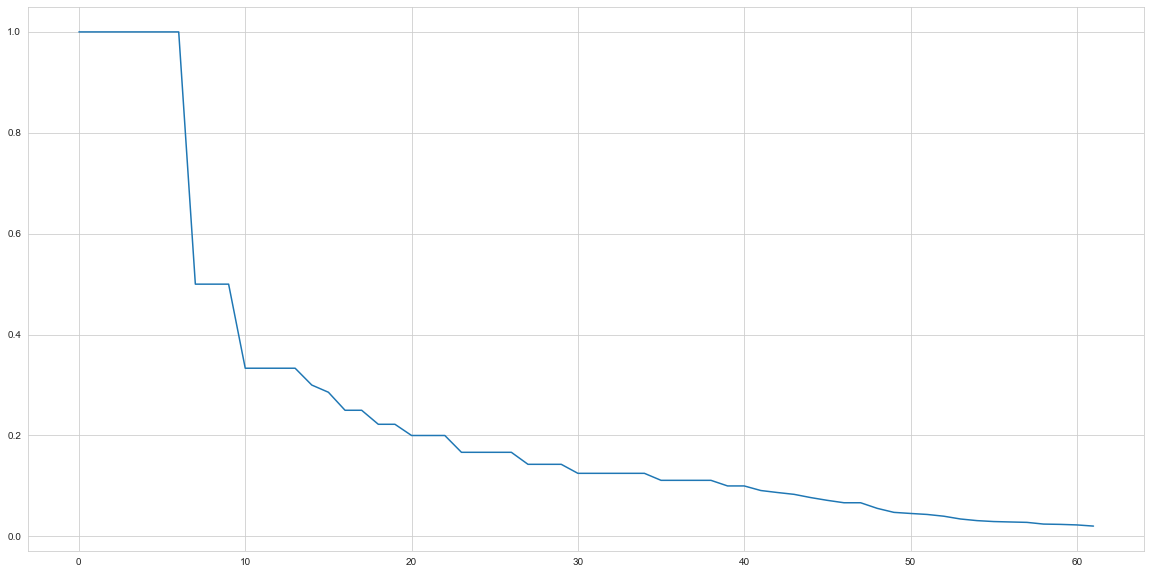

In [348]:
scores = rank_by_reliability(clusters_dict, intercluster_dists, contra_threshold=0.6)
sorted_clusters = sorted(scores, reverse=True)  # each element is (score, cluster_index)
scores_only = [score for score, _ in sorted_clusters]
import matplotlib.pyplot as plt
plt.plot(scores_only)

## Previous Single Summary Algo.

In [ ]:
from nltk.tokenize import RegexpTokenizer

def choose_longest(sentences):
    tokenizer = RegexpTokenizer(r'\w+')
    max_len = 0
    final_sent = None
    for sent in sentences:
        tokens = tokenizer.tokenize(sent)
        if len(tokens) > max_len:
            max_len = len(sent)
            final_sent = sent
    return final_sent

from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
def choose_salient(sentences):
    """
    
    """
    lxr = LexRank(sentences, stopwords=STOPWORDS['en'])
    top_sentence = lxr.get_summary(sentences[0], summary_size=1, threshold=.1)
    return top_sentence[0]
    

def summarize(clusters, intersentence, sent_df, word_limit=90, coherence_threshold=0.6, redundancy_threshold=0.3):
    """
    :param clusters: dict of clusters of the form {str(cluster_num): list(sentence_indices)}.
    :param intersentence: Pandas DataFrame of precomputed inter-sentence distance in pairwise matrix form.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param word_limit: maximum num of words for summary.
    :param coherence_threshold: maximum distance allowed for a sentence pair within the summary. valid values between 0-1.
    :param redundancy_threshold: minimum distance allowed for a sentence pair within the summary. valid values between 0-1.
    
    We need a redundancy_threshold because the clustering algorithm does not always manage to group 
    redundant sentences together?
    """
    if coherence_threshold <= redundancy_threshold:
        raise Exception
    
    tokenizer = RegexpTokenizer(r'\w+') # tokenize into word-like tokens.
    summary = list()
    word_count = 0
    
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)  # iterable of pairs.
    
    for key, clust in sorted_clusters:
        sentences = [sent_df.iloc[idx]['sentence'] for idx in clust]
        #selected = choose_longest(clust)
        selected = choose_salient([sentences])
        selected_idx = sent_df[sent_df.sentence == selected].index[0]
        tokens = tokenizer.tokenize(selected)
        if word_count + len(tokens) < word_limit:
            max_dist = 0
            min_dist = 1
            for sent_idx in summary:
                dist = intersentence.iloc[sent_idx][selected_idx]
                if dist > max_dist:
                    max_dist = dist
                if dist < min_dist:
                    min_dist = dist
            if max_dist < coherence_threshold and min_dist > redundancy_threshold:
                summary.append(selected_idx)
                word_count = word_count + len(tokens)
        else:
            break
    return summary

In [ ]:
# test lexrank algorithm.
sentences = [sents_df.iloc[idx]['sentence'] for idx in clusters_dict['0']]
display(sentences)
choose_salient([sentences])

In [ ]:
# todo: think of statistical way to determine the coherence_threshold and redundancy_threshold.
summary = summarize(clusters_dict, intersentence, sents_df, word_limit=90, coherence_threshold=0.6, redundancy_threshold=0.35)
print("no. of sentences in summary: ", len(summary))
print("no. of sentences in source: ", len(intersentence.index.values))
print()
for sent_idx in summary:
    print(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}")
print()
for sent_idx in sorted(summary):
    print(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}")

## Multiple Summaries (deprecated)

In [ ]:
def multi_summary(clusters, intercluster_dists, sent_df, word_limit=100, contradiction_threshold=0.6):
    """
    :param clusters: dict of clusters of the form {str(cluster_index): list(sentence_indices)}.
    :param intercluster_dists: square numpy.ndarray representing distances between each cluster.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param word_limit: maximum num of words for summary.
    :param contradiction_threshold: float value between 0 and 1, representing the value after which
    sentence pairs will be considered contradictory.
    """
    # find top/representative sentence of each cluster.
    top_sentences = dict()
    for clust_idx, clust in clusters.items():
        sentences = [sent_df.iloc[idx]['sentence'] for idx in clust]
        selected = choose_salient([sentences])
        selected_idx = sent_df[sent_df.sentence == selected].index[0]
        top_sentences[int(clust_idx)] = selected_idx  # typecasted to int because json dicts saved integer keys into str keys.
    
    # find clusters that are not contradictory w ALL other clusters.
    base_clusters = list()
    contradicted_pairs = list()
    contradicted_set= set()
    for i in range(len(intercluster_dists)):
        for j in range(i+1,len(intercluster_dists)):
            if intercluster_dists[i][j] > contradiction_threshold:
                contradicted_pairs.append((i,j))
                contradicted_set.add(i)
                contradicted_set.add(j)
        if i not in contradicted_set:
            base_clusters.append(i)
    
    # construct base summary
    base_summary = list()
    word_count = 0
    tokenizer = RegexpTokenizer(r'\w+') # tokenize into word-like tokens.
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)  # iterable of pairs.
    for clust_idx, clust in sorted_clusters:
        if int(clust_idx) in base_clusters:
            selected_idx = top_sentences[int(clust_idx)]
            selected = sent_df.iloc[selected_idx]['sentence']
            tokens = tokenizer.tokenize(selected)
            if word_count + len(tokens) < word_limit:
                base_summary.append(selected_idx)
                word_count = word_count + len(tokens)
            else:
                break
    
    # construct summaries w contentious information.
    all_summaries = list()
    added_sentences = set()
    for clust1, clust2 in contradicted_pairs:
        sent1 =  top_sentences[clust1]
        sent2 =  top_sentences[clust2]
        
        if sent1 not in added_sentences:
            all_summaries.append(base_summary + [sent1])
            added_sentences.add(sent1)
        if sent2 not in added_sentences:
            all_summaries.append(base_summary + [sent2])
            added_sentences.add(sent2)
    print(base_summary)
    return all_summaries, base_summary

In [ ]:
from IPython.display import Markdown
all_summaries, base_summary = multi_summary(clusters_dict, intercluster_dists, sents_df, word_limit=90, contradiction_threshold=0.6)

print(f"total no. of summaries = {len(all_summaries)}")
print()

for summary in all_summaries:
    print("no. of sentences in summary: ", len(summary))
    print("no. of sentences in source: ", len(intersentence.index.values))
    print()
    for sent_idx in sorted(summary):
        if sent_idx in base_summary:
            display(Markdown(f"**{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}**"))
        else:
            display(Markdown(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}"))
    print()